Could not load font from GitHub: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /TAFFETAPUNK/Assets/main/Font/SIGNWOOD-VNVD7.TTF (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D109FC5A90>, 'Connection to raw.githubusercontent.com timed out. (connect timeout=30)')). Using local font instead.
Could not load logo from GitHub: Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.. Using local image instead.


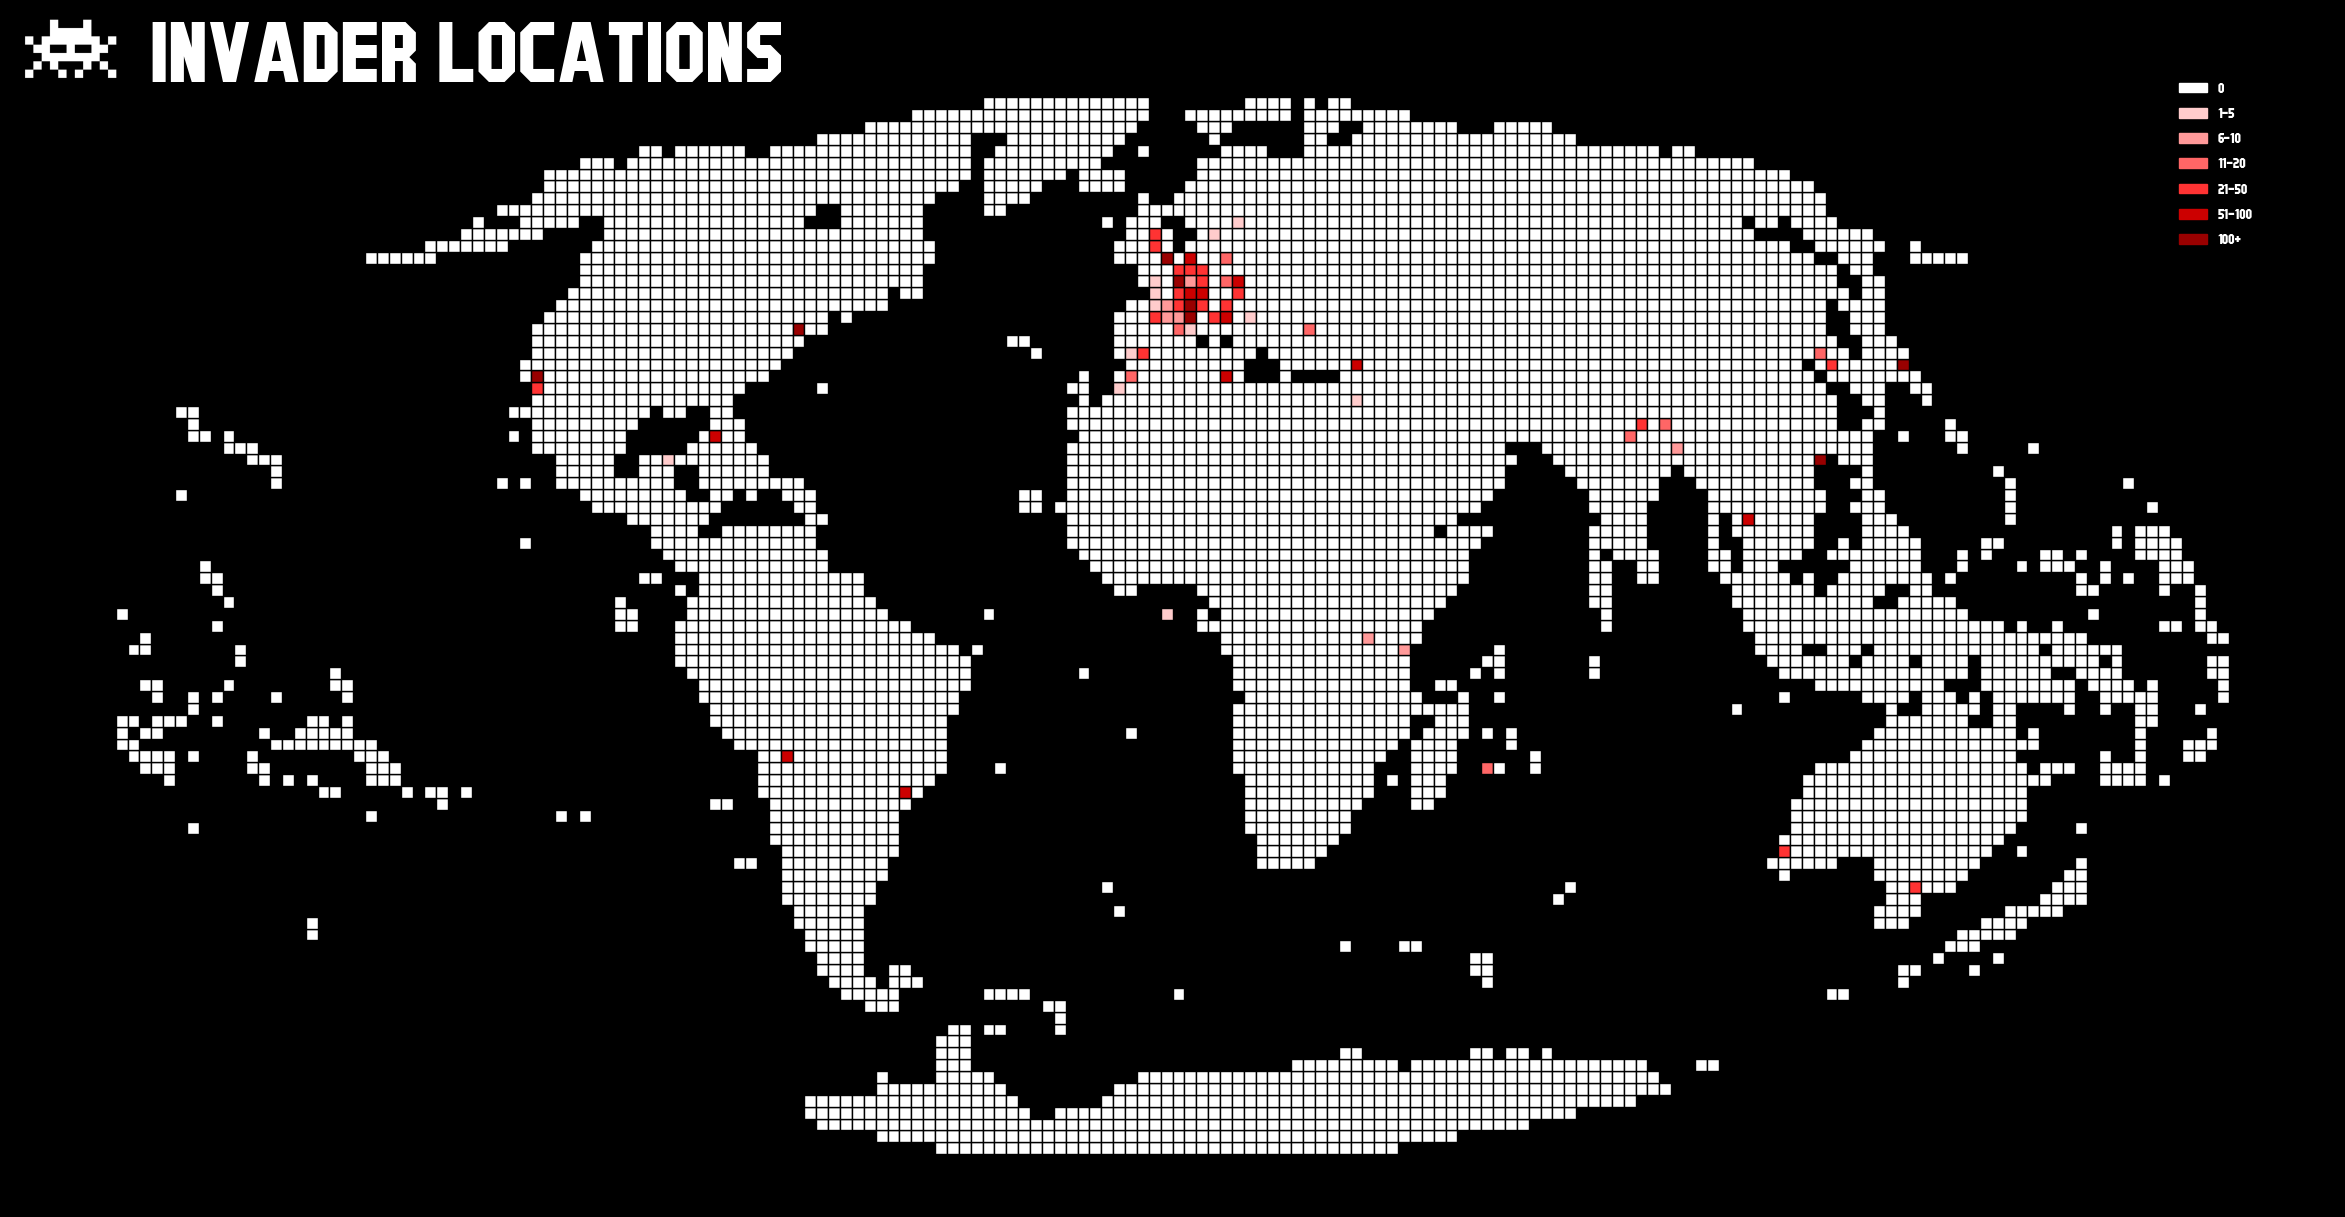

In [93]:
# -------------------------------
# Standard Libraries
import io
import urllib.request

# Third-Party Libraries
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box

# Local Application Imports
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

# -------------------------------
# 1. Load custom font from GitHub with fallback
font_url = "https://raw.githubusercontent.com/TAFFETAPUNK/Assets/main/Font/SIGNWOOD-VNVD7.TTF"
try:
    r = requests.get(font_url, timeout=30)
    r.raise_for_status()  # Ensure download succeeded
    font_bytes = io.BytesIO(r.content)
    pixel_font = fm.FontProperties(fname=font_bytes)
    print("Font loaded from GitHub.")
except Exception as e:
    print(f"Could not load font from GitHub: {e}. Using local font instead.")
    pixel_font = fm.FontProperties(fname=r"C:\Users\higgsl\AppData\Local\Microsoft\Windows\Fonts\Signwood-vnvD7.ttf")

# -------------------------------
# 2. Load shapefile
world_map = gpd.read_file("C:/Users/higgsl/Python Projects/Shapemaps/ne_10m_land.shp")
world_map = world_map.to_crs("ESRI:54009")

# -------------------------------
# 3. Define grid size
grid_size = 200000
xmin, ymin, xmax, ymax = world_map.total_bounds
cols = np.arange(xmin, xmax, grid_size)
rows = np.arange(ymin, ymax, grid_size)
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=world_map.crs)

# -------------------------------
# 4. Intersect grid with land
land_union = world_map.geometry.union_all()
land_grid = grid[grid.intersects(land_union)].copy()

# -------------------------------
# 5. Load city CSV
cities = pd.read_csv("C:/Users/higgsl/Python Projects/Datasets/invader_city_locations.csv")
cities_gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.Longitude, cities.Latitude), crs="EPSG:4326")
cities_gdf = cities_gdf.to_crs("ESRI:54009")

# -------------------------------
# 6. Spatial join to assign cities to grid squares
joined = gpd.sjoin(cities_gdf, land_grid, how="inner", predicate="within", lsuffix='left', rsuffix='right')

# -------------------------------
# 7. Aggregate counts per grid square
grid_counts = joined.groupby('index_right')['Count'].sum()
land_grid['Count'] = land_grid.index.map(grid_counts).fillna(0)

# -------------------------------
# 8. Define color ranges for red shades
def red_shade(count):
    if count == 0:
        return "white"
    elif count <= 5:
        return "#FFCCCC"
    elif count <= 10:
        return "#FF9999"
    elif count <= 20:
        return "#FF6666"
    elif count <= 50:
        return "#FF3333"
    elif count <= 100:
        return "#CC0000"
    else:
        return "#990000"

land_grid['color'] = land_grid['Count'].apply(red_shade)

# -------------------------------
# 9. Plot map
fig, ax = plt.subplots(figsize=(30, 24))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

land_grid.plot(ax=ax, color=land_grid['color'], edgecolor="black")
plt.axis("off")

# -------------------------------
# 10. Title text
title_text = "INVADER LOCATIONS"
title_fontsize = 60
ax.text(0.06, 1.02, title_text, fontproperties=pixel_font, color="white",
        fontsize=title_fontsize, transform=ax.transAxes, va='top', ha='left')

# -------------------------------
# 11. Add logo from GitHub
logo_url = "https://raw.githubusercontent.com/TAFFETAPUNK/Assets/main/Images/invader_logo.png"
try:
    logo_img = mpimg.imread(logo_url)
except Exception as e:
    print(f"Could not load logo from GitHub: {e}. Using local image instead.")
    logo_img = mpimg.imread("C:/Users/higgsl/Python Projects/Images/invader_logo.png")

# Create inset axes inside the main plot
logo_ax = ax.inset_axes([0.001, 0.96, 0.05, 0.07])  # Inside plot area
logo_ax.imshow(logo_img)
logo_ax.set_facecolor("black")
logo_ax.axis("off")

# -------------------------------
# 12. Define legend entries
legend_elements = [
    mpatches.Patch(color='white', label='0'),
    mpatches.Patch(color='#FFCCCC', label='1–5'),
    mpatches.Patch(color='#FF9999', label='6–10'),
    mpatches.Patch(color='#FF6666', label='11–20'),
    mpatches.Patch(color='#FF3333', label='21–50'),
    mpatches.Patch(color='#CC0000', label='51–100'),
    mpatches.Patch(color='#990000', label='100+')
]

# Add legend to top right corner, slightly shifted left
ax.legend(handles=legend_elements, 
          title="Count", 
          loc='upper right',
          bbox_to_anchor=(0.97, 1),  # Shifted slightly left
          frameon=False, 
          title_fontproperties=pixel_font, 
          prop=pixel_font,
          labelcolor='white', 
          labelspacing=1.1,
          fontsize=14)

# -------------------------------
# Show plot
plt.show()